In [127]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math

In [128]:
train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

In [129]:
projectId='pongthorn'
dataset_id='DemoSMartDW'
dw_table_id = f"{projectId}.{dataset_id}.incident"

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"

file_name="ML_Incident.csv"

client = bigquery.Client(project=projectId)

In [130]:
isLastUpdate=True

IsNewData=False

label='severity_id'
labelName='severity_name'

threshold_x_sd = 3  # 2.5/3/3.5


removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']




# Explore and Transform Data

In [131]:
def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all


In [132]:
imported_to='2023-04-04'  # for test  date+1 of the day that you perform
#imported_to='2023-03-13' For production
#updated_to='2023-03-13' # For test

sql_all=f"""
SELECT  id,severity_id,severity_name
,count_detail
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime, response_datetime,resolved_datetime
,updated_at,imported_at

FROM `{dw_table_id}`    

WHERE imported_at< '{imported_to}'

order  by imported_at
"""
#WHERE updated_at< '{updated_to}'
#WHERE imported_at< '{imported_to}'

# copy sql statement to check whether to be valid or not
print(sql_all)


SELECT  id,severity_id,severity_name
,count_detail
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime, response_datetime,resolved_datetime
,updated_at,imported_at

FROM `pongthorn.DemoSMartDW.incident`    

WHERE imported_at< '2023-04-04'

order  by imported_at



In [136]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
if len(df_all)==0:
 print("No records from bigquery")  
 quit()
else:
 print(df_all.shape)   

Load data from Bigquery
(2418, 15)


In [137]:
df_all=df_all.drop_duplicates(subset=['id'],keep='last')

no_original_rows=len(df_all)

df_all.info()

Original data = 2418
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2418 entries, 0 to 2417
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2418 non-null   Int64         
 1   severity_id        2418 non-null   Int64         
 2   severity_name      2418 non-null   object        
 3   count_detail       2418 non-null   Int64         
 4   sla                2418 non-null   object        
 5   product_type       2418 non-null   object        
 6   brand              2418 non-null   object        
 7   service_type       2418 non-null   object        
 8   incident_type      2418 non-null   object        
 9   open_datetime      2418 non-null   datetime64[ns]
 10  close_datetime     2418 non-null   datetime64[ns]
 11  response_datetime  2418 non-null   datetime64[ns]
 12  resolved_datetime  2418 non-null   datetime64[ns]
 13  updated_at         2418 non-null   datetim

# Manage Numberic Cols
Converting the data of these columns to hourly time period., it is more informative


In [138]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


#df_all[listDiffHourCols].describe()
df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05])

,open_to_close_hour,open_to_response_hour,response_to_resolved_hour
count,2418.000000,2418.000000,2418.000000
mean,174.198229,3.967894,133.719279
std,739.248077,39.531696,681.510174
min,0.000000,0.000000,0.000000
5%,0.966667,0.000000,0.166667
25%,4.066667,0.050000,2.670833
50%,8.891667,0.166667,6.666667
75%,48.000000,0.500000,26.000000
95%,810.216667,7.858333,503.682500
max,13177.250000,1152.133333,13176.250000


# Remove outlier on Time Interval to service

In [139]:
# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")


no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

print(df_all.info())

% remove data 2.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2367 entries, 0 to 2417
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   id                                2367 non-null   Int64          
 1   severity_id                       2367 non-null   Int64          
 2   severity_name                     2367 non-null   object         
 3   count_detail                      2367 non-null   Int64          
 4   sla                               2367 non-null   object         
 5   product_type                      2367 non-null   object         
 6   brand                             2367 non-null   object         
 7   service_type                      2367 non-null   object         
 8   incident_type                     2367 non-null   object         
 9   open_datetime                     2367 non-null   datetime64[ns] 
 10  close_datetime    

# Find any rows  contain zero time period
## it doesn't make any sense on real world 

In [141]:
# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
    
  # open_to_response_hour =o is not realistic  ==> move columns  
# No. 0-hour row on open_to_response_hour = 456(19.2 %) , it is relevant to site manage's behaviod
# They get incident call from customer  and provide engineer to response completely
# afte that they will enter the application to record case 

No. 0-hour row on count_detail = 116(4.9 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 454(19.2 %)
No. 0-hour row on response_to_resolved_hour = 99(4.2 %)


# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

In [143]:
# https://www.geeksforgeeks.org/pandas-cut-method-in-python/


def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

# range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
# print(explore_ranges_numberic_val('open_to_response_hour',range3))
# print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

# we can convert hour to range   
# (0, 24] =by 1 day =best
# (24, 168] =  1day -1 week  =good
# (168, 360]=  1week- 15 days(half a month) =fair
# (360, 720]= 15 dasy-1 month =bad
# (720, 2349]=1 month-1 Q =worst

# open_to_close_hour ,response_to_resolved_hour , mostly  we can complate by 1 day (0, 24]
# there are few cased that take long to close incident (360, 720]   15 day to  1month

open_to_close_hour
(0, 24]        1602
(24, 168]       484
(168, 360]      121
(720, 2349]      94
(360, 720]       64
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 24]        1673
(24, 168]       390
(168, 360]       96
(720, 2016]      62
(360, 720]       46
Name: response_to_resolved_hour, dtype: int64
count_detail
(0, 2]     1787
(2, 4]      281
(4, 36]     183
Name: count_detail, dtype: int64


In [144]:
#Anyway , We will have 2 columns left 
print("remove some cate featurs that have undeisred data")

# open_to_response_hour :No. 0-hour row on open_to_response_hour = 456(19.2 %)
# ount_detail  : 80%  (0, 2] =1790 You'll notice that most of the data is clustered in (0, 2] detail  only
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have undeisred data


['open_to_close_hour', 'response_to_resolved_hour']

In [145]:
# remove response_to_resolved_hour ,it doesn't make any sense
# No. 0-hour row on response_to_resolved_hour = 99(4.2 %)
df_all=df_all.query('response_to_resolved_hour!=0')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 0 to 2417
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   id                                2268 non-null   Int64          
 1   severity_id                       2268 non-null   Int64          
 2   severity_name                     2268 non-null   object         
 3   count_detail                      2268 non-null   Int64          
 4   sla                               2268 non-null   object         
 5   product_type                      2268 non-null   object         
 6   brand                             2268 non-null   object         
 7   service_type                      2268 non-null   object         
 8   incident_type                     2268 non-null   object         
 9   open_datetime                     2268 non-null   datetime64[ns] 
 10  close_datetime                    22

# Drop unnessay columns

In [146]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 0 to 2417
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2268 non-null   Int64  
 1   severity_name              2268 non-null   object 
 2   sla                        2268 non-null   object 
 3   product_type               2268 non-null   object 
 4   brand                      2268 non-null   object 
 5   service_type               2268 non-null   object 
 6   incident_type              2268 non-null   object 
 7   open_to_close_hour         2268 non-null   float64
 8   response_to_resolved_hour  2268 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 179.4+ KB


In [147]:
df_all[numbericCols].describe(percentiles=[.95,.75,.50,.25,.05])
# 95% vs max

,open_to_close_hour,response_to_resolved_hour
count,2268.000000,2268.000000
mean,96.548236,70.595437
std,265.404032,217.022654
min,0.083333,0.016667
5%,1.000000,0.516667
25%,4.133333,3.000000
50%,8.750000,7.000000
75%,42.287500,26.000000
95%,585.544167,343.715000
max,2348.183333,2016.883333


# Plot Numeric  columns

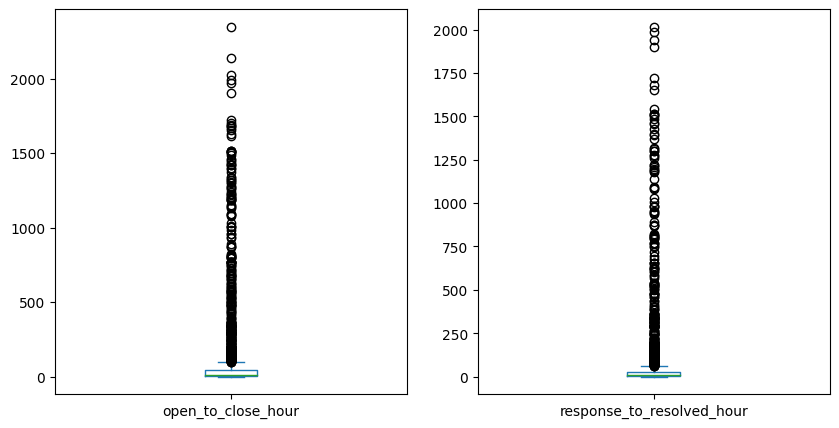

In [148]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

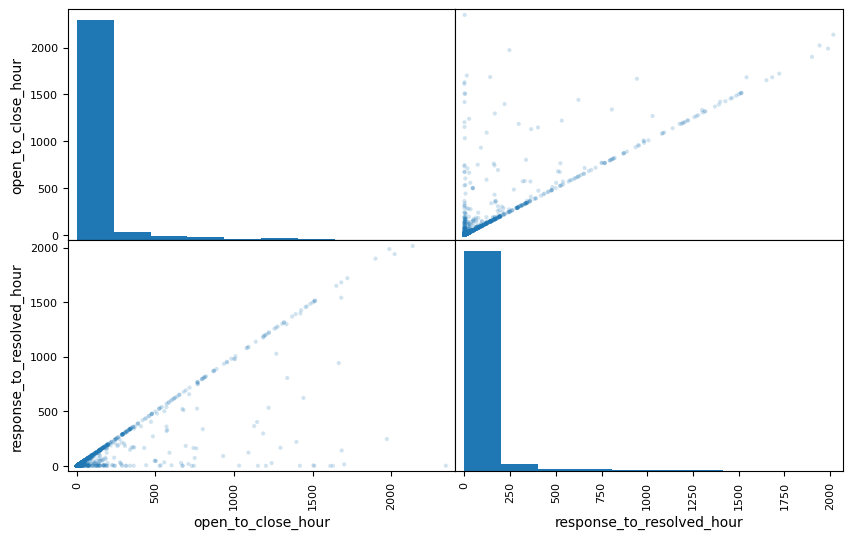

In [149]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

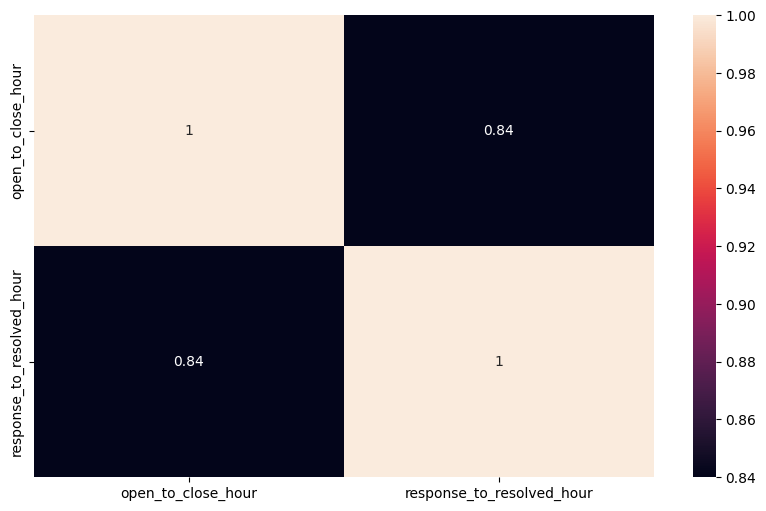

In [150]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Plot Categorical Cols

In [151]:
VBar=['brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]
HBar.insert(0,'severity_name')

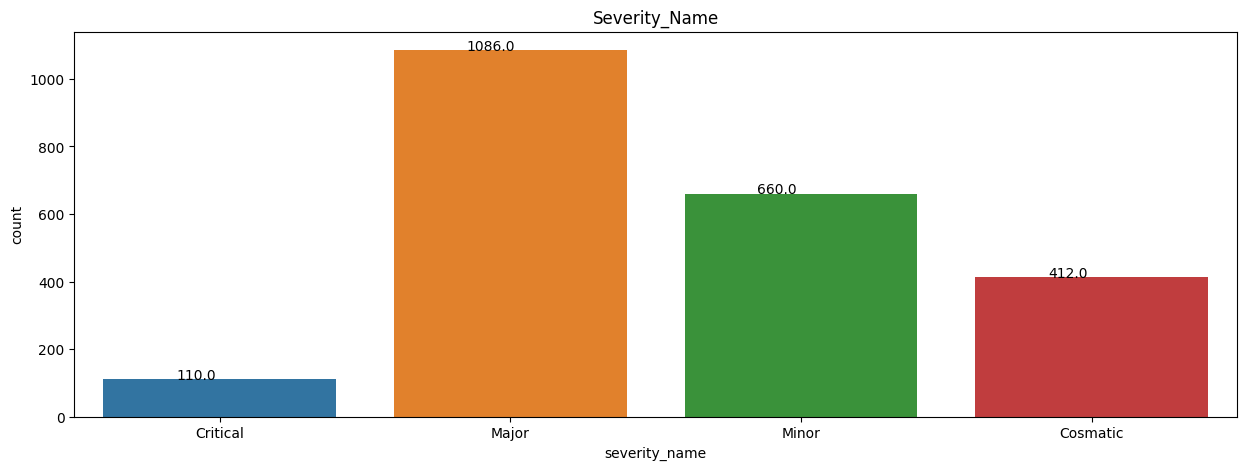

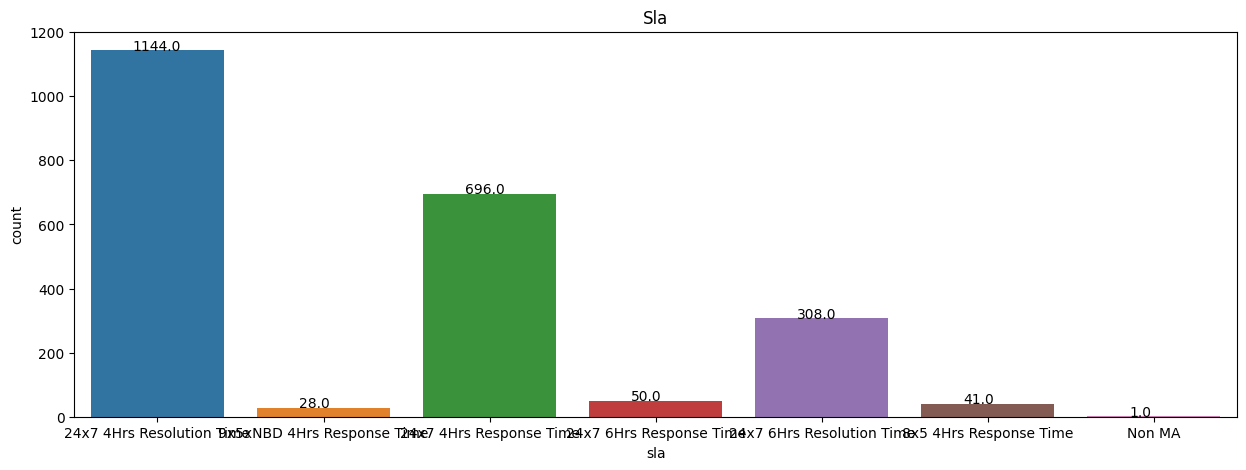

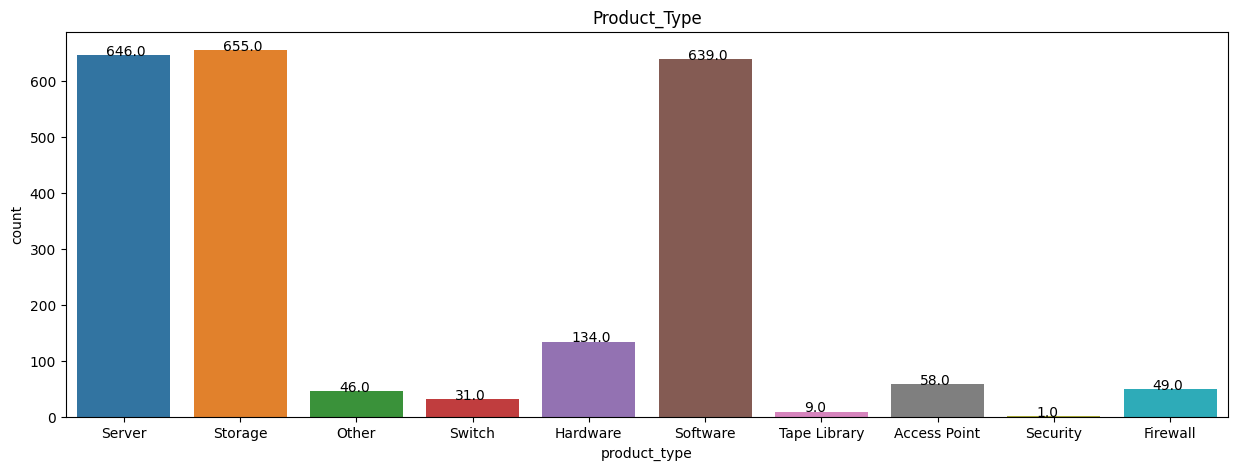

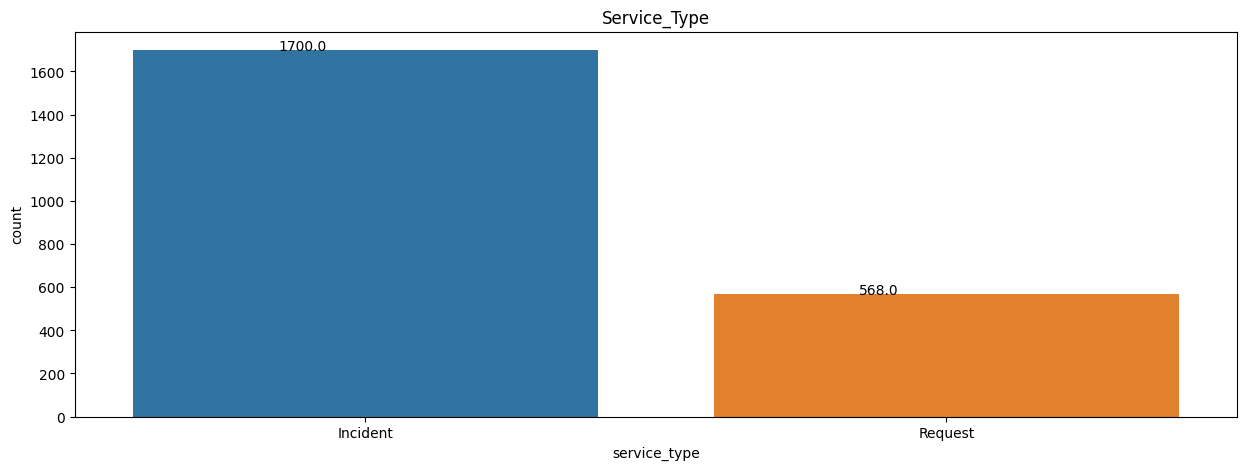

In [152]:
for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

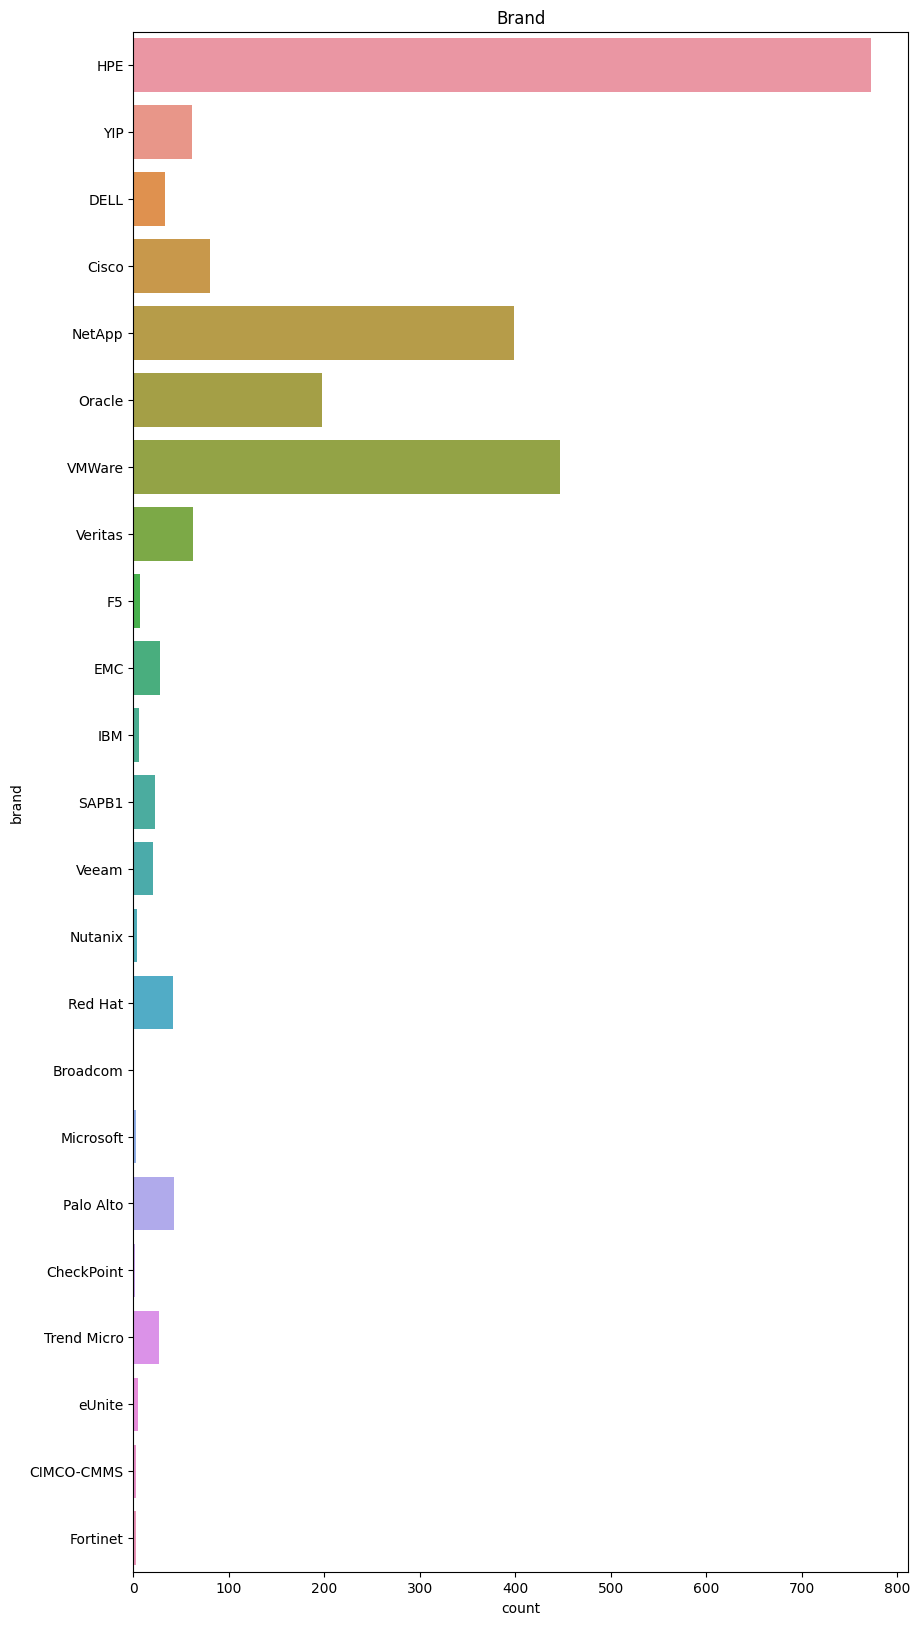

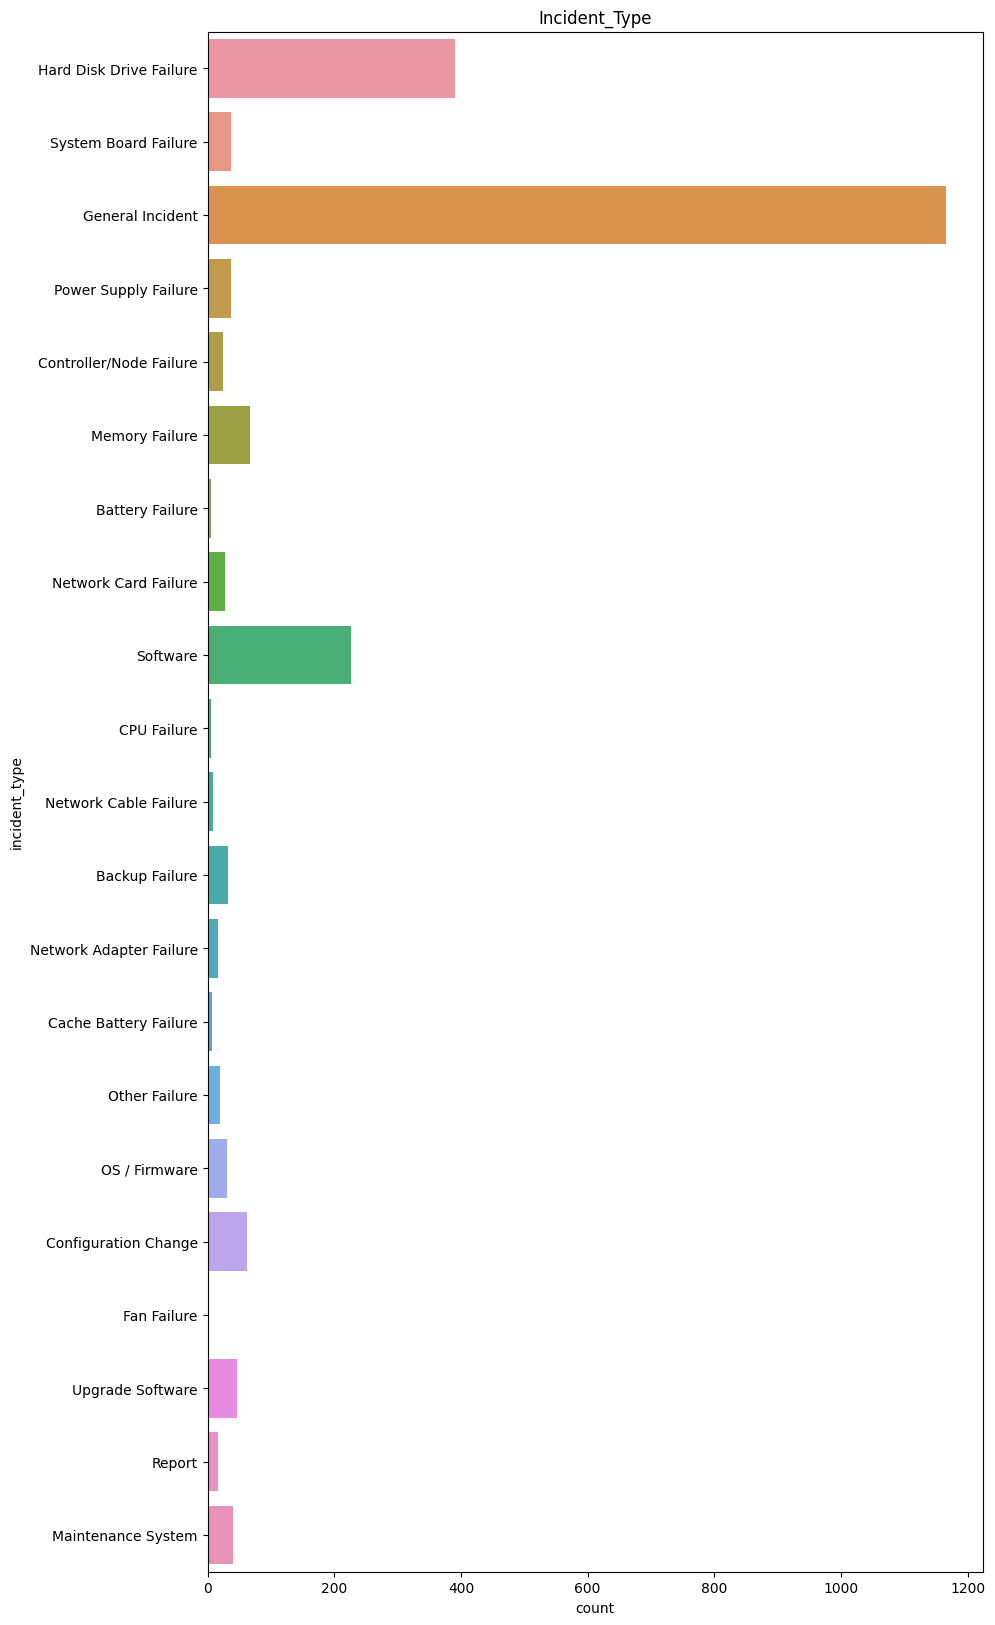

In [153]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

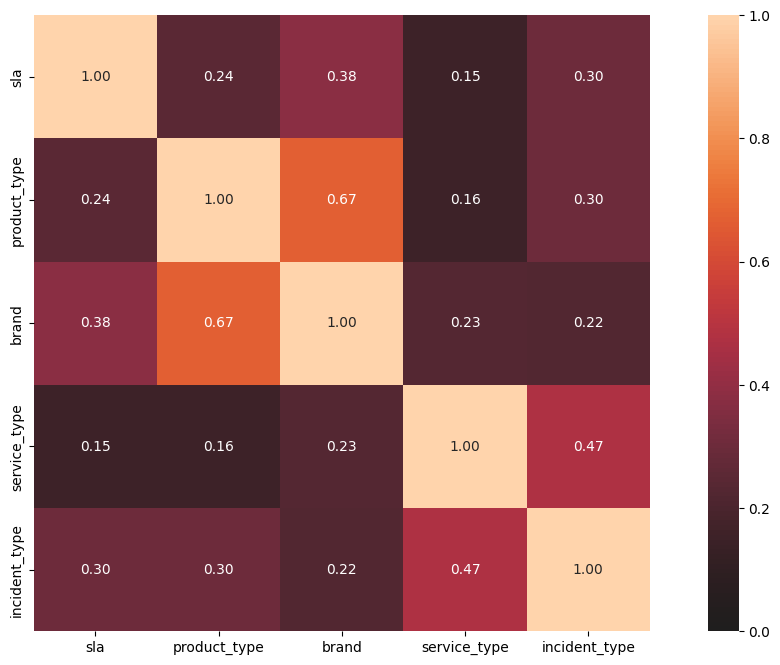

In [154]:
# all of them are not hardly relevant, it is hight variance
complete_correlation= associations(df_all[ cateCols ], figsize=(15,8))

In [155]:
print(df_all.info())
df_all.to_csv(f"data/{file_name}",index=False)
#bucket_name="gs://smart-ml-pongthorn"
# df_all.to_csv(f"{bucket_name}/{file_name}",index=False) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 0 to 2417
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2268 non-null   Int64  
 1   severity_name              2268 non-null   object 
 2   sla                        2268 non-null   object 
 3   product_type               2268 non-null   object 
 4   brand                      2268 non-null   object 
 5   service_type               2268 non-null   object 
 6   incident_type              2268 non-null   object 
 7   open_to_close_hour         2268 non-null   float64
 8   response_to_resolved_hour  2268 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 179.4+ KB
None


# Build Training DataSet

In [156]:
# create label
map_sevirity_to_class={'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}
print(f"Map severity Name to LabelCode: {str(map_sevirity_to_class)}")

Map severity Name to LabelCode: {'Cosmatic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [157]:
df_all['label_multi_severity'] =df_all['severity_name'].map(map_sevirity_to_class) 
def map_4to2_serverity(severity_id):
    if severity_id==1 or severity_id==2:
       return 1
    else:
       return 0 
df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

print( list(df_all['label_multi_severity'].unique()))
print(df_all['label_binary_severity'].unique())
df_all.head()

[3, 2, 1, 0]
[1 0]


,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity,label_binary_severity
0,1,Critical,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,4.600000,4.500000,3,1
1,1,Critical,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,10.000000,9.866667,3,1
2,1,Critical,24x7 4Hrs Resolution Time,Server,HPE,Incident,System Board Failure,4.066667,4.000000,3,1
3,1,Critical,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,4.766667,4.700000,3,1
4,1,Critical,24x7 4Hrs Resolution Time,Storage,HPE,Incident,General Incident,1.566667,1.500000,3,1


In [158]:
#Split data into 3 dataset to BQ
len_all=len(df_all)
print(f"All Data = {len_all}")

# Split the 80% of total as train
# The remaining  will be splited equally 50% for valuation and the rest of later part is test

train, val = train_test_split(df_all,test_size=0.2,random_state=1000,shuffle=True)
val,test = train_test_split(val, test_size=0.5,random_state=1000,shuffle=True)

len_all=len(df_all)
len_train=len(train)
len_val=len(val)
len_test=len(test)
print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
print(f'{len_val} =val examples ({round(len_val/len_all*100,1)}%)')
print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

All Data = 2268
1814 =train examples (80.0%)
227 =val examples (10.0%)
227 =test examples (10.0%)


In [164]:
print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable

pct removed data =6.20347394540943


In [165]:
def loadDataFrameToBQ(table_id,dfx):
    try:
        job_config = bigquery.LoadJobConfig(
            write_disposition="WRITE_TRUNCATE",
        )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"{len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))
            
# save to csv file to load faster than bigquery
train.to_csv(f"data/{train_name}.csv",index=False)
val.to_csv(f"data/{validation_name}.csv",index=False)
test.to_csv(f"data/{test_name}.csv",index=False)

#write_disposition="WRITE_TRUNCATE"
#google will create table and load data into them automaticall 
loadDataFrameToBQ(f"{train_table_id}",train)
loadDataFrameToBQ(f"{val_tabel_id}",val)
loadDataFrameToBQ(f"{test_tabel_id}",test)   
    

1814 rows imported to pongthorn.DemoSMartDW.train_incident successfully
227 rows imported to pongthorn.DemoSMartDW.validation_incident successfully
227 rows imported to pongthorn.DemoSMartDW.test_incident successfully
